In [1]:
import catboost as cb
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
df = pd.read_csv('earthquakes.csv')

df.time = pd.to_datetime(df.time)
df = df.loc[df.time >= "1974-01-01"]
df = df.sort_values("time")
df = df.set_index("time")

df["region"] = df.place.str.split(", ", expand=True)[1]
df.region = df.region.fillna(df.place)
df.region = df.region.replace("CA", "California")
df.region = df.region.replace("B.C.", "Baja California")

regions = df.region.value_counts()
top_k = 25
top_k_regions = regions.head(top_k).index

In [3]:
model = cb.CatBoostRegressor(cat_features=['region'])
model = model.load_model('model_depth_10_2')

In [4]:
start_lag = 3
end_lag = 12
features = [
    "day",
    "dayofweek",
    "dayofyear",
    f"mag_rolling_mean_{start_lag}",
    f"mag_rolling_std_{start_lag}",
    f"depth_rolling_mean_{start_lag}",
    f"depth_rolling_std_{start_lag}",
    f"latitude_rolling_mean_{start_lag}",
    f"latitude_rolling_std_{start_lag}",
    f"longitude_rolling_mean_{start_lag}",
    f"longitude_rolling_std_{start_lag}",
    f"mag_rolling_mean_{end_lag}",
    f"mag_rolling_std_{end_lag}",
    f"depth_rolling_mean_{end_lag}",
    f"depth_rolling_std_{end_lag}",
    f"latitude_rolling_mean_{end_lag}",
    f"latitude_rolling_std_{end_lag}",
    f"longitude_rolling_mean_{end_lag}",
    f"longitude_rolling_std_{end_lag}",
] + [f"mag_lag_{i}" for i in range(start_lag, end_lag + 1)]
cat_features = ["region"]
target = "mag"

In [5]:
live_data = pd.read_csv(
    "https://earthquake.usgs.gov/fdsnws/event/1/query?format=csv&eventtype=earthquake&limit=20000"
)
live_data.time = pd.to_datetime(live_data.time)
live_data = live_data.sort_values("time")
live_data = live_data.set_index("time")

live_data["region"] = live_data.place.str.split(", ", expand=True)[1]
live_data.region = live_data.region.fillna(live_data.place)
live_data.region = live_data.region.replace("CA", "California")
live_data.region = live_data.region.replace("B.C.", "Baja California")

live_data = live_data.loc[live_data.region.isin(top_k_regions)]

live_data.depth = live_data.depth.astype("float32")
live_data.mag = live_data.mag.astype("float32")

live_data = live_data[["depth", "mag", "region", 'latitude', 'longitude']]

live_data = live_data.groupby("region").resample("d").mean()
live_data = live_data.reset_index()
live_data.mag = live_data.mag.ffill()
live_data.depth = live_data.depth.ffill()
live_data.latitude = live_data.latitude.ffill()
live_data.longitude = live_data.longitude.ffill()

live_data["day"] = live_data.time.dt.day
live_data["month"] = live_data.time.dt.month
live_data["dayofweek"] = live_data.time.dt.dayofweek
live_data["dayofyear"] = live_data.time.dt.dayofyear

for i in range(start_lag, end_lag + 1):
    live_data[f"mag_lag_{i}"] = live_data.groupby("region").mag.shift(i)

live_data[f"mag_rolling_mean_{start_lag}"] = live_data.groupby("region").mag.transform(
    lambda x: x.rolling(window=start_lag).mean()
)
live_data[f"mag_rolling_std_{start_lag}"] = live_data.groupby("region").mag.transform(
    lambda x: x.rolling(window=start_lag).std()
)
live_data[f"depth_rolling_mean_{start_lag}"] = live_data.groupby("region").depth.transform(
    lambda x: x.rolling(window=start_lag).mean()
)
live_data[f"depth_rolling_std_{start_lag}"] = live_data.groupby("region").depth.transform(
    lambda x: x.rolling(window=start_lag).std()
)
live_data[f"latitude_rolling_mean_{start_lag}"] = live_data.groupby("region").latitude.transform(
    lambda x: x.rolling(window=start_lag).mean()
)
live_data[f"latitude_rolling_std_{start_lag}"] = live_data.groupby("region").latitude.transform(
    lambda x: x.rolling(window=start_lag).std()
)
live_data[f"longitude_rolling_mean_{start_lag}"] = live_data.groupby("region").longitude.transform(
    lambda x: x.rolling(window=start_lag).mean()
)
live_data[f"longitude_rolling_std_{start_lag}"] = live_data.groupby("region").longitude.transform(
    lambda x: x.rolling(window=start_lag).std()
)

live_data[f"mag_rolling_mean_{end_lag}"] = live_data.groupby("region").mag.transform(
    lambda x: x.rolling(window=end_lag).mean()
)
live_data[f"mag_rolling_std_{end_lag}"] = live_data.groupby("region").mag.transform(
    lambda x: x.rolling(window=end_lag).std()
)
live_data[f"depth_rolling_mean_{end_lag}"] = live_data.groupby("region").depth.transform(
    lambda x: x.rolling(window=end_lag).mean()
)
live_data[f"depth_rolling_std_{end_lag}"] = live_data.groupby("region").depth.transform(
    lambda x: x.rolling(window=end_lag).std()
)
live_data[f"latitude_rolling_mean_{end_lag}"] = live_data.groupby("region").latitude.transform(
    lambda x: x.rolling(window=end_lag).mean()
)
live_data[f"latitude_rolling_std_{end_lag}"] = live_data.groupby("region").latitude.transform(
    lambda x: x.rolling(window=end_lag).std()
)
live_data[f"longitude_rolling_mean_{end_lag}"] = live_data.groupby("region").longitude.transform(
    lambda x: x.rolling(window=end_lag).mean()
)
live_data[f"longitude_rolling_std_{end_lag}"] = live_data.groupby("region").longitude.transform(
    lambda x: x.rolling(window=end_lag).std()
)

In [6]:
live_data.head()

,region,time,depth,mag,latitude,longitude,day,month,dayofweek,dayofyear,...,longitude_rolling_mean_3,longitude_rolling_std_3,mag_rolling_mean_12,mag_rolling_std_12,depth_rolling_mean_12,depth_rolling_std_12,latitude_rolling_mean_12,latitude_rolling_std_12,longitude_rolling_mean_12,longitude_rolling_std_12
0,Alaska,2024-04-29 00:00:00+00:00,24.387457,0.754576,59.320369,-155.233721,29,4,0,120,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Alaska,2024-04-30 00:00:00+00:00,20.107187,0.804359,58.759742,-155.917433,30,4,1,121,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Alaska,2024-05-01 00:00:00+00:00,29.993999,0.868000,59.541299,-153.265623,1,5,2,122,...,-154.805592,1.376770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Alaska,2024-05-02 00:00:00+00:00,29.736809,1.896581,57.190819,-156.537044,2,5,3,123,...,-155.240033,1.737729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Alaska,2024-05-03 00:00:00+00:00,26.109306,1.037333,59.858427,-154.918426,3,5,4,124,...,-154.907031,1.635741,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
live_prediction = model.predict(live_data[features + cat_features])
print(f"Mean Absolute Error: {mean_absolute_error(live_data[target], live_prediction)}")
print(
    f"Root Mean Squared Error: {np.sqrt(mean_squared_error(live_data[target], live_prediction))}"
)
print(f"R2 Score: {r2_score(live_data[target], live_prediction)}")

Mean Absolute Error: 0.3113233297917245
Root Mean Squared Error: 0.5588756318235
R2 Score: 0.883703396237598


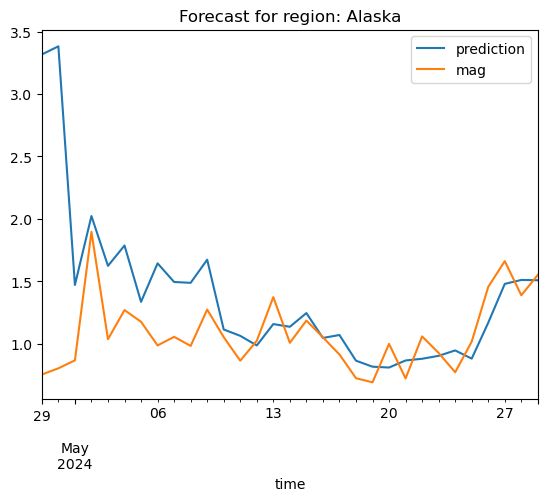

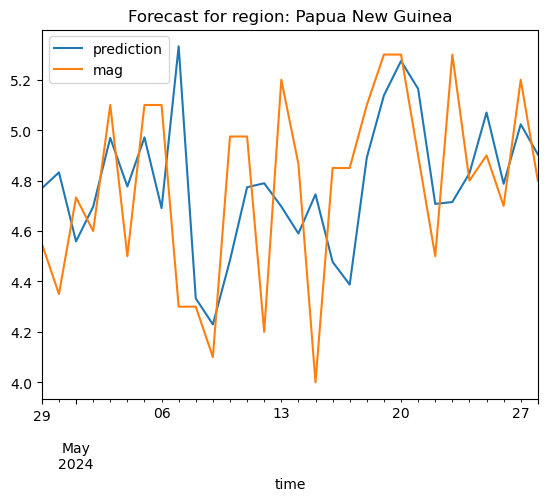

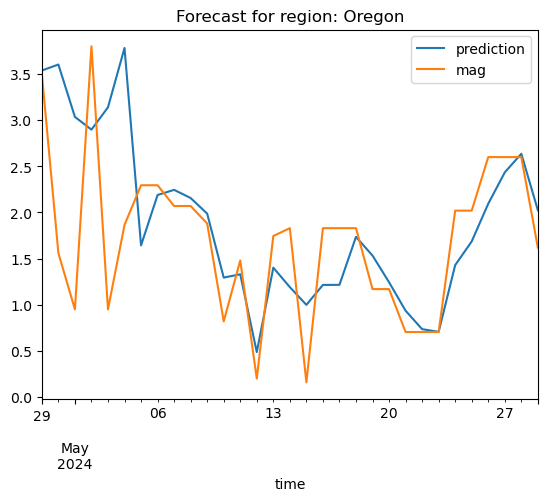

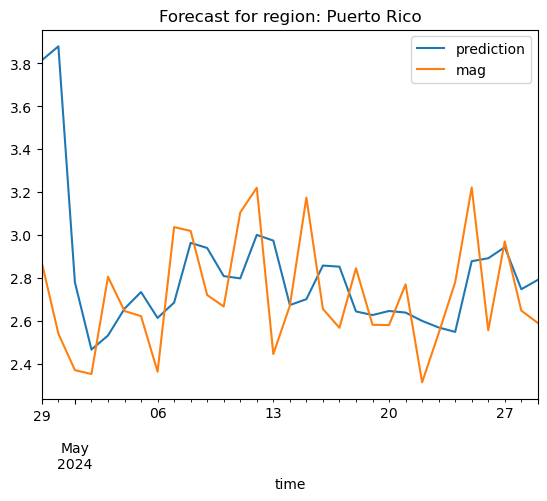

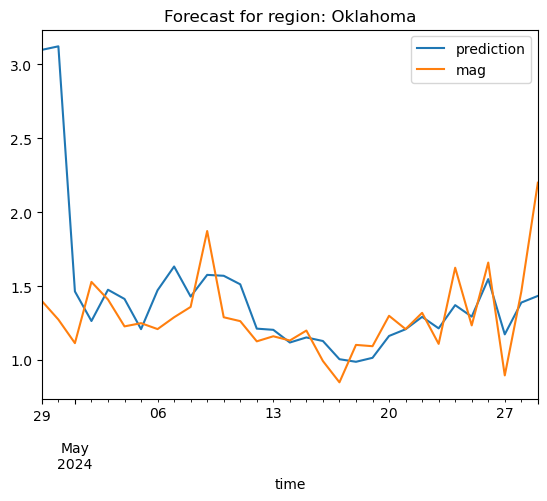

In [8]:
df_live = pd.DataFrame({'region': live_data.region, 'mag': live_data[target], 'prediction': live_prediction, 'time': live_data.time})
df_live = df_live.sort_values(by='time')

k = 5
for region in df_live.region.unique():
    df_region = df_live.loc[df_live.region == region]
    df_region.plot(title=f"Forecast for region: {region}", x='time', y=['prediction', 'mag'])
    k -= 1
    if not k:
        break